In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import h5py as h
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import statistics as st
import os
import pickle
import glob
from scipy import stats
%matplotlib inline
import random
import seaborn as sn
from IPython.display import display, HTML
from scipy.stats import norm
import pandas as pd
display(HTML("<style>.container { width:90% !important; }</style>"))

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

In [9]:
def Get_hit_array(file, Current_Event,particle):
    data = h.File(file,'r')
    TotalEvents=int(data['MC']['configuration'][2][1])
    if(TotalEvents < Current_Event):
        print('out of event range')

    Current_Hit_Mask = data['MC']['hits']['event_id'] == Current_Event 
    Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event
    Hits_PIDs=data['MC']['hits'][Current_Hit_Mask]['particle_id'] 
    Current_Particles=data['MC']['particles'][Current_Particle_Mask]

    Electron_Mask = Current_Particles['particle_name'] == particle

    Electron_PIDS = data['MC']['particles'][Current_Particle_Mask][Electron_Mask]['particle_id']         


    Hit_Electron_Maks = np.in1d(Hits_PIDs, Electron_PIDS)
    ElectronData=data['MC']['hits'][Current_Hit_Mask][Hit_Electron_Maks]

    return ElectronData


def Diffuser(HIT_ARRAY,ZOFFSET):
    Etotal = 0
    Diffused_X = np.array([])
    Diffused_Y = np.array([])
    Diffused_Z = np.array([])

    for hit in HIT_ARRAY:
        energy_deposit = hit['energy']
        electron_loc_x = hit['x']/10
        electron_loc_y = hit['y']/10
        #electron_loc_z = hit['z']/10 + Zoffset
        electron_loc_z = ZOFFSET

        Etotal += energy_deposit

        Nelectron = int( (energy_deposit*1e6/GasProps.Wvalue) );

        # Loop through the electrons 
        for electron in range(Nelectron):

            # calculate drift time for diffusion 
            T_drift = electron_loc_z / GasProps.Vd
            if (T_drift <=0):
                print("Warnign T_drift is negative")
                continue
            # electron lifetime
            if (np.random.uniform() >= np.exp(-T_drift/GasProps.Life_Time)):
                continue

            # diffuse the electrons position
            sigma_T = np.sqrt(2*GasProps.Dt*T_drift)
            sigma_L = np.sqrt(2*GasProps.Dl*T_drift)
            electron_x = np.random.normal(electron_loc_x,sigma_T)
            electron_y = np.random.normal(electron_loc_y,sigma_T)
            electron_z = np.random.normal(electron_loc_z,sigma_L)
            Diffused_X=np.append(Diffused_X,electron_x)
            Diffused_Y=np.append(Diffused_Y,electron_y)
            Diffused_Z=np.append(Diffused_Z,electron_z)
    print("evnet has {} MeV and made {} electrons".format(round(Etotal,3), len(Diffused_X)))
        
        
    return Diffused_X, Diffused_Y, Diffused_Z




def Diffuserv2(HIT_ARRAY,ZOFFSET):
    Etotal = 0
    Diffused_X = []
    Diffused_Y = []
    Diffused_Z = []

    for hit in HIT_ARRAY:
        energy_deposit = hit[3]
        electron_loc_x = hit[0]
        electron_loc_y = hit[1]
        #electron_loc_z = hit[2] + Zoffset
        electron_loc_z = ZOFFSET

        Etotal += energy_deposit

       
        # calculate drift time for diffusion 
        T_drift = electron_loc_z / GasProps.Vd
        if (T_drift <=0):
            print("Warnign T_drift is negative")
            continue
        # electron lifetime
        if (np.random.uniform() >= np.exp(-T_drift/GasProps.Life_Time)):
            continue

        # diffuse the electrons position
        sigma_T = np.sqrt(2*GasProps.Dt*T_drift)
        sigma_L = np.sqrt(2*GasProps.Dl*T_drift)
        electron_x = np.random.normal(electron_loc_x,sigma_T)
        electron_y = np.random.normal(electron_loc_y,sigma_T)
        electron_z = np.random.normal(electron_loc_z,sigma_L)
        Diffused_X.append(electron_x)
        Diffused_Y.append(electron_y)
        Diffused_Z.append(electron_z)
    print("evnet has {} MeV and made {} electrons".format(round(Etotal,3), len(Diffused_X)))
        
        
    return Diffused_X, Diffused_Y, Diffused_Z


def ionizationElectronPosition(data,mother,targetvolume='EL_GAP',EventLimit=2):
    TotalEvents=int(data['configuration'][2][1])
    values={}

    
    if(EventLimit>TotalEvents):
        EventLimit=TotalEvents
        
    for EventID in range(0,EventLimit):
        # obtain current event id
        EventIDMask=data["particles"]["event_id"]==EventID
        
        #store particle infor for this event
        ParticlesTable=data["particles"][EventIDMask]
        # Create Mother mask for expected mother
        MotherMask=ParticlesTable["particle_name"]==mother
        # Interested particles
        IonizationElectronsMask=ParticlesTable["final_volume"]==targetvolume
        #obtain mother idsprint(ParticlesInInterest["particle_name"][IonizationElectronsMask][MotherIDMask])
        IonizationElectronMotherID=ParticlesTable["mother_id"][IonizationElectronsMask]
        #Expected Mother IDs
        ExpectedMotherID=ParticlesTable["particle_id"][MotherMask]
        # Find intersection of the motherIds of ie and Expected Mother
        MotherIDMask=np.isin(IonizationElectronMotherID,ExpectedMotherID)
        FinalPositions=[ParticlesTable["final_x"][IonizationElectronsMask][MotherIDMask],ParticlesTable["final_y"][IonizationElectronsMask][MotherIDMask],ParticlesTable["final_z"][IonizationElectronsMask][MotherIDMask]]
        values[EventID]=FinalPositions
    return values
        
def getvalues(file):
    data = h.File(file,'r')
    return data['MC']
                
    
class Gas_Properties():
    # gas values for 500V/cm at 10 bar
    # simulated from PyBoltz
    def __init__(self):
        #self.Wvalue = 22.1 # in eV
        #self.Vd = 935000.0 # cm/s
        #self.Dt = 6114.291 # cm**2/s
        #self.Dl = 506.464  # cm**2/s
        #self.Life_Time = 0.001 # in s
        
        self.Wvalue = 22.1 # in eV
        self.Vd = 94000 # cm/s
        self.Dt = 395.80 # cm**2/s
        self.Dl = 61.15  # cm**2/s
        self.Life_Time = 0.001 # in s
        
        
        
GasProps = Gas_Properties()


def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)    
    return data


def MultiFileIonizationElectronPosition(files,mother,TargetVolume=b'EL_GAP',TargetParticle=b'opticalphoton',EventLimit=2,FileName="Optical.p"):
    count=0
    values={}
    
    if(EventLimit==-1):
        EventLimit=len(files)
    filecount=0
    for file in files:
        print(f"Analyzing following  file --> {file}\n" )
        data = getvalues(file)
        TotalEvents=int(data['configuration'][2][1])
        FinalPosition={"particle_name":[],"x":[],"y":[],"z":[]}
    
        for EventID in range(0,TotalEvents):
            #Obtain current event id
            EventIDMask=data["particles"]["event_id"]==EventID
            
            #Store particle infor for this event
            ParticlesTable=data["particles"][EventIDMask]
            
            #Create Mother mask for expected mother
            MotherMask=ParticlesTable["particle_name"]==mother
            
            ## Particle Name Mask
            
            #Interested particles
            ParticleNameMask=ParticlesTable["particle_name"]==TargetParticle
            ParticlesInInterest=ParticlesTable[ParticleNameMask]
            if(TargetVolume!=None):
                IonizationElectronsMask=ParticlesInInterest["final_volume"]==TargetVolume
                ParticlesInInterest=ParticlesInInterest[IonizationElectronsMask]
           
            IonizationElectronMotherID=ParticlesInInterest["mother_id"]

            #Expected Mother IDs
            ExpectedMotherID=ParticlesTable["particle_id"][MotherMask]
            
            #Find intersection of the motherIds of ie and Expected Mother
            MotherIDMask=np.isin(IonizationElectronMotherID,ExpectedMotherID)
            FinalPosition["particle_name"]=ParticlesInInterest["particle_name"][MotherIDMask]
            FinalPosition["x"]=ParticlesInInterest["final_x"][MotherIDMask]
            FinalPosition["y"]=ParticlesInInterest["final_y"][MotherIDMask]
            FinalPosition["z"]=ParticlesInInterest["final_z"][MotherIDMask]
            values[count]=FinalPosition
            count=count+1
            
        if(filecount>=EventLimit):
            break
        filecount=filecount+1
    if(FileName==""):
        PickleITDump(values,"Electrons.p")
    else:
        PickleITDump(values,FileName+".p")
    print("Events are saved!")
    return values



In [35]:
files=glob.glob("/media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/*.h5",recursive=True)

In [36]:
#ie=MultiFileIonizationElectronPosition(files,mother=b'alpha',TargetVolume=None,TargetParticle=b'ie-',EventLimit=-1,FileName="ionizationElectrons.p")
#Op=MultiFileIonizationElectronPosition(files,mother=b'alpha',TargetVolume=None,TargetParticle=b'opticalphoton',EventLimit=-1,FileName="Optical.p")
#ieNoS1=MultiFileIonizationElectronPosition(files,mother=b'alpha',TargetVolume=None,TargetParticle=b'ie-',EventLimit=-1,FileName="ionizationElectronsWithNoS1.p")


Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_100_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_10_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_11_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_12_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_13_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_14_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_15_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_16_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_17_9.7_bar.h5

Analyzing followin

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_79_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_7_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_80_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_81_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_82_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_83_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_84_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_85_9.7_bar.h5

Analyzing following  file --> /media/ilker/Ilker/SimResults/Mar11_2023/Updated_NoS1/output/S2_86_9.7_bar.h5

Analyzing following 

In [46]:
NumPhoton=np.array([])
NumE=np.array([])
NumEv2=np.array([])

for o in Op:
    NumPhoton=np.append(NumPhoton,len(Op[o]["particle_name"]))

for p in ie:
    NumE=np.append(NumE,len(ie[p]["particle_name"]))


for k in ieNoS1:
    NumEv2=np.append(NumEv2,len(ieNoS1[k]["particle_name"]))
        

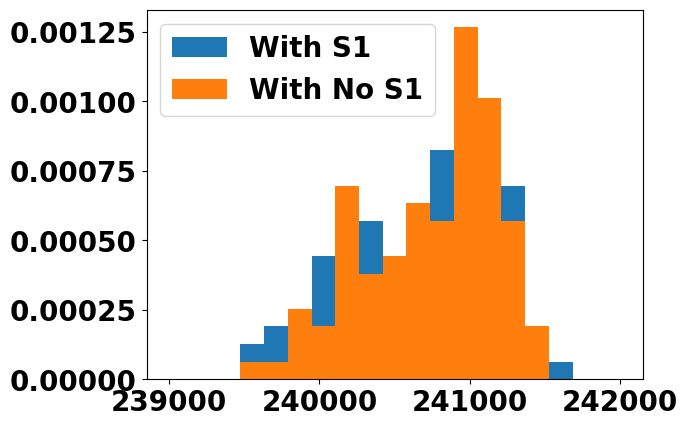

In [54]:
binns=np.linspace(239000,242000,20)
plt.hist(NumE,bins=binns,stacked=True,density=True,label="With S1")
plt.hist(NumEv2,bins=binns,stacked=True,density=True,label="With No S1")
plt.legend()
plt.show()

In [ ]:
### GEANT4



In [ ]:
filePath="/media/ilker/Ilker/SimResults/Jan_20_2022/Alpha_Prediction.h5"


In [ ]:
data=getvalues(filePath)

In [ ]:
Alphaies=ionizationElectronPosition(data,b'alpha',b'EL_GAP',100)

In [ ]:
for Event in Alphaies.keys():
    X=(Alphaies[Event][0])/10
    Y=Alphaies[Event][1]/10
    bins = [np.arange(-10, 10, 0.02), np.arange(-10, 10, 0.02)]
    cmap = plt.get_cmap('cividis')
    cmap = plt.get_cmap('afmhot')

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    #ax1.set_title("GEANT4 Diffusion at 5cm")


    h1 = ax1.hist2d(X, Y, bins=bins, cmap=cmap)

    #cbar1 = plt.colorbar(h1[3])
    #cbar1.set_label('Electrons', fontsize=18)
    #cbar1.ax.tick_params(labelsize=18)
    # cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

    #ax1.set_ylabel(r'Y  [cm]',fontsize=18)
    #ax1.set_xlabel(r'X  [cm]',fontsize=18)
    #ax1.tick_params(labelsize=18)
    ax1.set_xlim(-10,10)
    ax1.set_ylim(-10,10)
    plt.axis('off')
    path="/media/ilker/Ilker/SimResults/Jan_20_2022/Particles/Predictions/Alpha/Alphas_"+str(Event)+".png"
    plt.tight_layout()
    plt.savefig(path,dpi=300,bbox_inches='tight')
    #plt.show()
    plt.close()

In [ ]:
filePath="/media/ilker/Ilker/SimResults/Jan_20_2022/Betas_Prediction.h5"
data=getvalues(filePath)

In [ ]:
Betas=ionizationElectronPosition(data,b'e-',b'EL_GAP',500)

In [ ]:
print(Betas)


In [ ]:
for Event in Betas.keys():
    X=(Betas[Event][0])/10
    Y=Betas[Event][1]/10
    bins = [np.arange(-10, 10, 0.02), np.arange(-10, 10, 0.02)]
    cmap = plt.get_cmap('cividis')
    cmap = plt.get_cmap('afmhot')

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    #ax1.set_title("GEANT4 Diffusion at 5cm")


    h1 = ax1.hist2d(X, Y, bins=bins, cmap=cmap)

    #cbar1 = plt.colorbar(h1[3])
    #cbar1.set_label('Electrons', fontsize=18)
    #cbar1.ax.tick_params(labelsize=18)
    # cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

    #ax1.set_ylabel(r'Y  [cm]',fontsize=18)
    #ax1.set_xlabel(r'X  [cm]',fontsize=18)
    #ax1.tick_params(labelsize=18)
    ax1.set_xlim(-10,10)
    ax1.set_ylim(-10,10)
    plt.axis('off')
    path="/media/ilker/Ilker/SimResults/Jan_20_2022/Particles/Predictions/Beta/Betas_"+str(Event)+".png"
    plt.tight_layout()
    plt.savefig(path,dpi=300,bbox_inches='tight')
    #plt.show()
    plt.close()

In [ ]:
#### 